# 未来価格の予測  

## 予測対象: 未来の価格と今の価格の値上がり率（対数）  
$$y = \log{\frac{future\_price}{current\_price}} = \log{future\_price} - \log{current\_price}$$  

直接求めるか，未来価格を予測して比率を計算するか．  

## 使用する特徴量  
- 画像の特徴量（SwinTransformerで抽出）
- 直近50件の価格推移（LSTMで抽出）   
- 各コレクションの価格平均  

## モデルの構成  
- 画像の特徴量をSwinTransformerで抽出（64）  
- 価格推移を特徴量として抽出  
- 上2つと価格平均を結合して，機械学習モデルで予測（モデルは要検討）  

### 結果  
- linear regression: mae 0.322  
- lightgbm: mae 0.246  
- NN: 0.275  

In [1]:
from comet_ml import Experiment

import os
import sys
import gc
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import lightgbm as lgb
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optim
import tensorflow.keras.activations as activations
import matplotlib.pyplot as plt

sys.path.append('../src')
sys.path.append('../Swin-Transformer-TF')
from ml_utils import *
from utils import *
from swintransformer import SwinTransformer

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 20


%matplotlib inline

In [2]:
TABLE_DIR = "../data/taskA/table"
en_df = pd.read_csv(os.path.join(TABLE_DIR, "ensemble_data.csv"))  # 各画像データをSwinTransformerで特徴量抽出したデータを含む
en_df = en_df.drop('target', axis=1)
en_df = en_df.rename(columns={'price_0': 'target'})
en_df['target'] = en_df['target'].apply(lambda x: np.log1p(x))

print(f"ensemble data shape: {en_df.shape}")

ensemble data shape: (21747, 235)


In [3]:
en_df = en_df.query("price_1 != 0").reset_index(drop=True)
en_df = en_df[en_df['collection.name'] != 'Angry Apes United']  # 1つしか存在しないもの
collection_means = en_df.groupby('collection.name')['price_1'].mean()
en_df['target_encoding'] = en_df['collection.name'].map(collection_means)
print(f"drop 1 transaction data: {en_df.shape}")

drop 1 transaction data: (13530, 236)


In [4]:
def create_model(len_seq: int = 49, input_dim: int = 1, output_dim: int = 1):
    inputs = layers.Input(shape=(len_seq, input_dim))
    lstm = layers.LSTM(64)(inputs)
    outputs = layers.Dense(output_dim)(lstm)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=losses.mean_squared_error, optimizer=optim.Adam())
    return model

In [5]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


2021-12-20 22:23:04.294497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 22:23:04.300092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 22:23:04.300552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 22:23:04.301275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
features = [f"price_{i}" for i in range(1, 50)]
target = 'target'

X = en_df[features].values.reshape(-1, 49, 1)
y = en_df[target].values

model.fit(X, y, validation_split=0.1, epochs=20, batch_size=64)

Epoch 1/20


2021-12-20 22:23:04.807808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-20 22:23:06.016876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


 47/191 [======>.......................] - ETA: 0s - loss: 2.6529 

2021-12-20 22:23:06.542638: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


191/191 [==============================] - 2s 3ms/step - loss: 1.6250 - val_loss: 0.2081
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 1.1175 - val_loss: 0.2767
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0747 - val_loss: 0.3960
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0794 - val_loss: 0.1494
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0510 - val_loss: 0.3302
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0667 - val_loss: 0.2511
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0722 - val_loss: 0.2226
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0598 - val_loss: 0.2934
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0397 - val_loss: 0.2505
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 1.0537 - val_loss: 0.1552
Epoch 11/2

In [7]:
base_model = models.Sequential(model.layers[:-1])
seq_features = base_model.predict(X)

seq_names = [f"seq_feature{i}" for i in range(64)]
en_df[seq_names] = seq_features

In [8]:
image_names = [f"image_feature{i}" for i in range(64)]
use_cols = seq_names + image_names + ['target_encoding']
target = 'target'

In [9]:
experiment = Experiment(
    api_key=get_comet_ml_key(),
    project_name="nft-appraiser",
    workspace="nft-appraiser",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/nft-appraiser/nft-appraiser/be80106205ee459583c583d4bd117973



In [10]:
def eval_model(df, features, target, model, model_name):
    kf = StratifiedKFold(n_splits=4, random_state=6174, shuffle=True)
    rmse_scores = np.array([])
    mae_scores = np.array([])
    model_no = 0
    models = {}

    for train_idx, val_idx in kf.split(df, df['collection.name'].values):
        train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

        enc = train_df.groupby(['collection.name'])['target'].mean()
        train_df['target_encoding'] = train_df['collection.name'].map(enc)
        val_df['target_encoding'] = val_df['collection.name'].map(enc)

        train_X, val_X = train_df[features].values, val_df[features].values
        train_y, val_y = train_df[target].values, val_df[target].values

        sc = StandardScaler()
        train_X = sc.fit_transform(train_X)
        val_X = sc.transform(val_X)

        model.fit(train_X, train_y)
        pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_y, pred))
        mae = mean_absolute_error(val_y, pred)

        rmse_scores = np.append(rmse_scores, rmse)
        mae_scores = np.append(mae_scores, mae)

        models[f"model_{model_no}"] = model
        model_no += 1

    print(f"Use model: {model_name}")
    print(f"RMSE Score: {rmse_scores.mean()}")
    print(f"MAE Score: {mae_scores.mean()}")

    return models

In [11]:
linear_models = eval_model(en_df, use_cols, target, LinearRegression(), "Linear Regression")

Use model: Linear Regression
RMSE Score: 1.409202677952957
MAE Score: 0.3224544893026327


In [12]:
lgb_models = eval_model(en_df, use_cols, target, lgb.LGBMRegressor(), "Light GBM")

Use model: Light GBM
RMSE Score: 0.6458726214011261
MAE Score: 0.24585027633148349


In [13]:
X = en_df[use_cols].values
pred = np.zeros(len(X))
for model in lgb_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))
en_df['pred'] = pred / 4

In [14]:
en_df[['target', 'pred']].describe()

,target,pred
count,13530.000000,13530.000000
mean,1.420694,1.640486
std,1.446046,1.290927
min,0.000000,-0.108557
25%,0.463734,0.982234
50%,1.029619,1.169657
75%,1.856298,1.652208
max,19.336971,12.832126


In [15]:
en_df['real_rate'] = en_df['target'] - en_df['price_1'].apply(lambda x: np.log1p(x))
en_df['pred_rate'] = en_df['pred'] - en_df['price_1'].apply(lambda x: np.log1p(x))
en_df[['real_rate', 'pred_rate']].describe()

,real_rate,pred_rate
count,13530.000000,13530.000000
mean,0.213703,0.433495
std,1.036265,0.948100
min,-18.044203,-17.998238
25%,-0.044068,0.016226
50%,0.082541,0.403416
75%,0.303387,0.693054
max,18.749185,12.244339


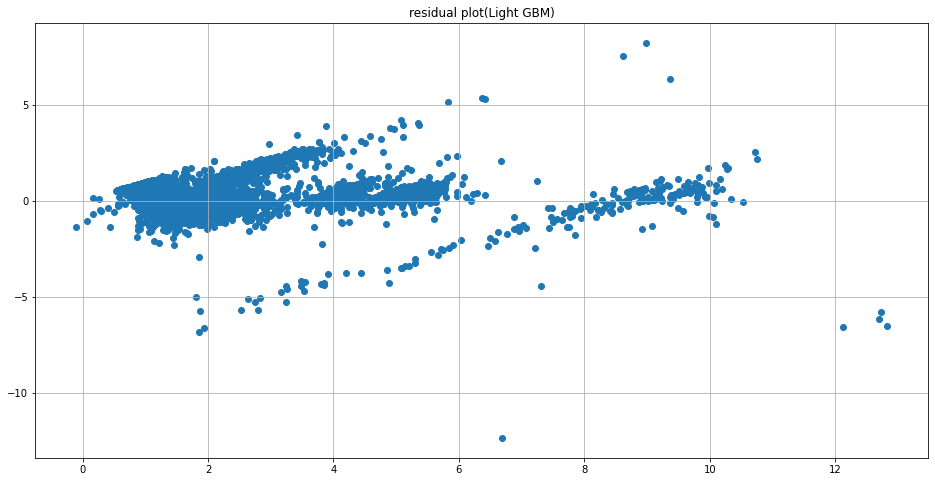

In [16]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred'], en_df['pred'] - en_df['target'])
plt.title("residual plot(Light GBM)")
plt.grid(True)
plt.show()

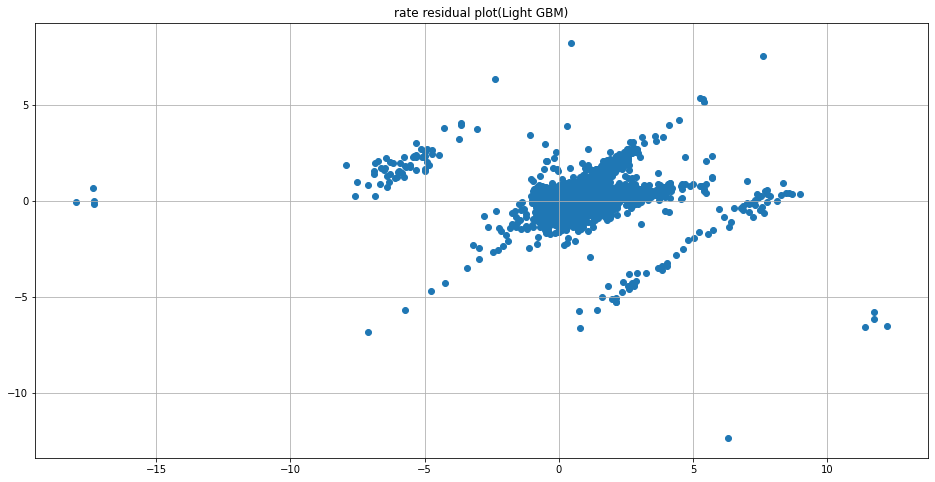

In [17]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate'], en_df['pred_rate'] - en_df['real_rate'])
plt.title("rate residual plot(Light GBM)")
plt.grid(True)
plt.show()

In [18]:
X = en_df[use_cols].values
pred = np.zeros(len(X))
for model in linear_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))

en_df['pred_linear'] = pred / 4
en_df['pred_rate_linear'] = en_df['pred_linear'] - en_df['price_1'].apply(lambda x: np.log1p(x))

en_df[['target', 'pred_linear']].describe()

,target,pred_linear
count,13530.000000,13530.000000
mean,1.420694,1.421550
std,1.446046,1.871099
min,0.000000,-147.687894
25%,0.463734,0.497989
50%,1.029619,1.060547
75%,1.856298,1.888934
max,19.336971,10.058549


In [19]:
en_df[['real_rate', 'pred_rate_linear']].describe()

,real_rate,pred_rate_linear
count,13530.000000,13530.000000
mean,0.213703,0.214559
std,1.036265,1.635649
min,-18.044203,-151.950574
25%,-0.044068,-0.047496
50%,0.082541,0.140414
75%,0.303387,0.371683
max,18.749185,9.293081


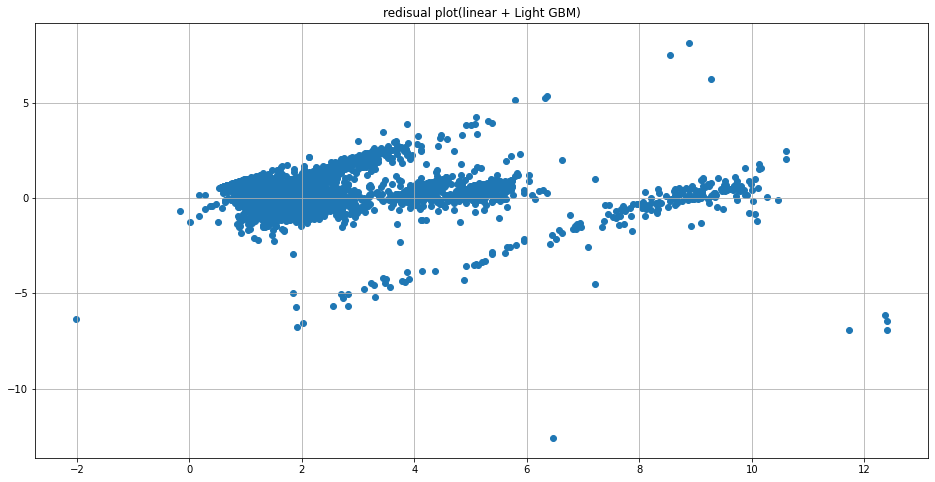

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_linear']*0.038 + en_df['pred']*0.962, en_df['pred_linear']*0.038 + en_df['pred']*0.962- en_df['target'])
plt.grid(True)
plt.title("redisual plot(linear + Light GBM)")
plt.show()

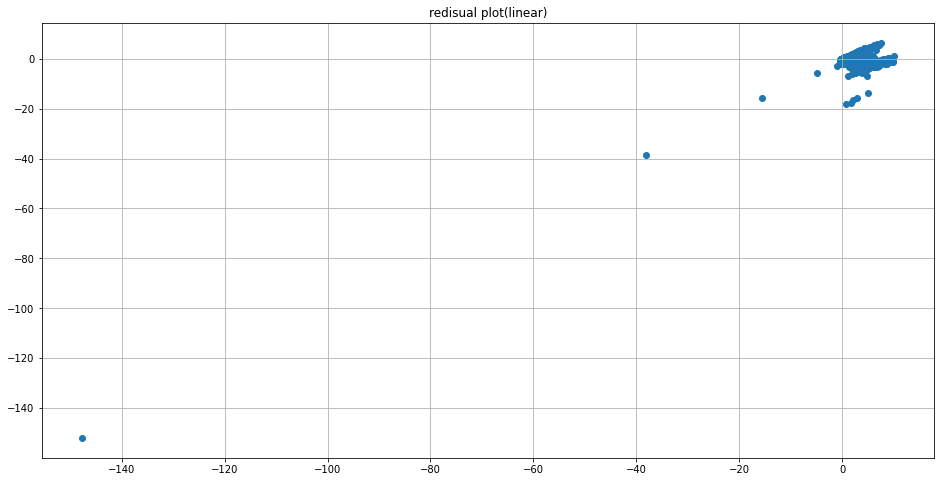

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_linear'], en_df['pred_linear'] - en_df['target'])
plt.grid(True)
plt.title("redisual plot(linear)")
plt.show()

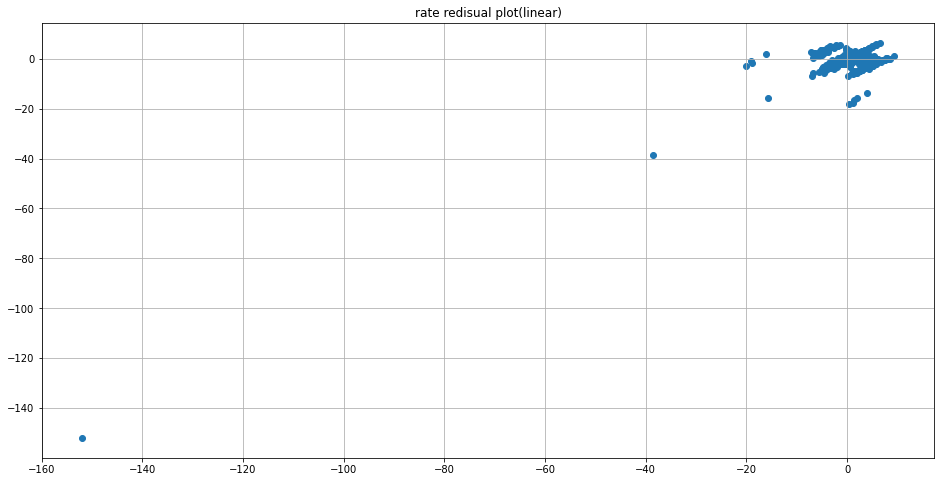

In [22]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate_linear'], en_df['pred_rate_linear'] - en_df['real_rate'])
plt.grid(True)
plt.title("rate redisual plot(linear)")
plt.show()

In [23]:
def create_meta_nn(input_dim: int = 129, output_dim: int = 1):
    inputs = layers.Input(shape=(input_dim))
    dense1 = layers.Dense(64, activation=None)(inputs)
    activation1 = layers.Activation(activations.gelu)(dense1)
    dr1 = layers.Dropout(0.5)(activation1)
    dense2 = layers.Dense(16, activation=None)(dr1)
    activation2 = layers.Activation(activations.gelu)(dense2)
    dr2 = layers.Dropout(0.3)(activation2)
    outputs = layers.Dense(1)(dr2)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss=losses.mean_squared_error, optimizer=optim.Adam())
    return model

In [24]:
meta_nn = create_meta_nn()
meta_nn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 129)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8320      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0   

In [25]:
def eval_nn(df, features, target):
    kf = StratifiedKFold(n_splits=4, random_state=6174, shuffle=True)
    rmse_scores = np.array([])
    mae_scores = np.array([])
    model_no = 0
    models = {}

    for train_idx, val_idx in kf.split(df, df['collection.name'].values):
        train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

        enc = train_df.groupby(['collection.name'])['target'].mean()
        train_df['target_encoding'] = train_df['collection.name'].map(enc)
        val_df['target_encoding'] = val_df['collection.name'].map(enc)

        train_X, val_X = train_df[features].values, val_df[features].values
        train_y, val_y = train_df[target].values, val_df[target].values

        model = create_meta_nn()
        model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y))
        pred = model.predict(val_X)
        rmse = np.sqrt(mean_squared_error(val_y, pred))
        mae = mean_absolute_error(val_y, pred)

        rmse_scores = np.append(rmse_scores, rmse)
        mae_scores = np.append(mae_scores, mae)

        models[f"model_{model_no}"] = model
        model_no += 1

    print("Use model: Neural Network")
    print(f"RMSE Score: {rmse_scores.mean()}")
    print(f"MAE Score: {mae_scores.mean()}")

    return models

In [26]:
nn_models = eval_nn(en_df, use_cols, target)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


Epoch 1/50
159/159 [==============================] - 0s 2ms/step - loss: 1.0249 - val_loss: 0.6919
Epoch 2/50
159/159 [==============================] - 0s 1ms/step - loss: 0.6990 - val_loss: 0.5816
Epoch 3/50
159/159 [==============================] - 0s 1ms/step - loss: 0.6919 - val_loss: 0.5978
Epoch 4/50
159/159 [==============================] - 0s 1ms/step - loss: 0.6513 - val_loss: 0.6250
Epoch 5/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5898 - val_loss: 0.5824
Epoch 6/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5954 - val_loss: 0.5999
Epoch 7/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5958 - val_loss: 0.5865
Epoch 8/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5965 - val_loss: 0.6127
Epoch 9/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5481 - val_loss: 0.5712
Epoch 10/50
159/159 [==============================] - 0s 1ms/step - loss: 0.5590 - val_loss: 0.5908

In [27]:
X = en_df[use_cols].values
pred = np.zeros((len(X), 1))
for model in nn_models.values():
    pred += model.predict(StandardScaler().fit_transform(X))

en_df['pred_nn'] = pred / 4
en_df['pred_rate_nn'] = en_df['pred_nn'] - en_df['price_1'].apply(lambda x: np.log1p(x))

en_df[['real_rate', 'pred_rate_nn']].describe()

,real_rate,pred_rate_nn
count,13530.000000,13530.000000
mean,0.213703,-2.226732
std,1.036265,7.982580
min,-18.044203,-291.513969
25%,-0.044068,-4.774751
50%,0.082541,-2.266920
75%,0.303387,-0.382377
max,18.749185,90.007588


In [28]:
en_df[['target', 'pred_nn']].describe()

,target,pred_nn
count,13530.000000,13530.000000
mean,1.420694,-1.019742
std,1.446046,8.717986
min,0.000000,-291.434696
25%,0.463734,-4.109622
50%,1.029619,-1.257050
75%,1.856298,1.271071
max,19.336971,90.509575


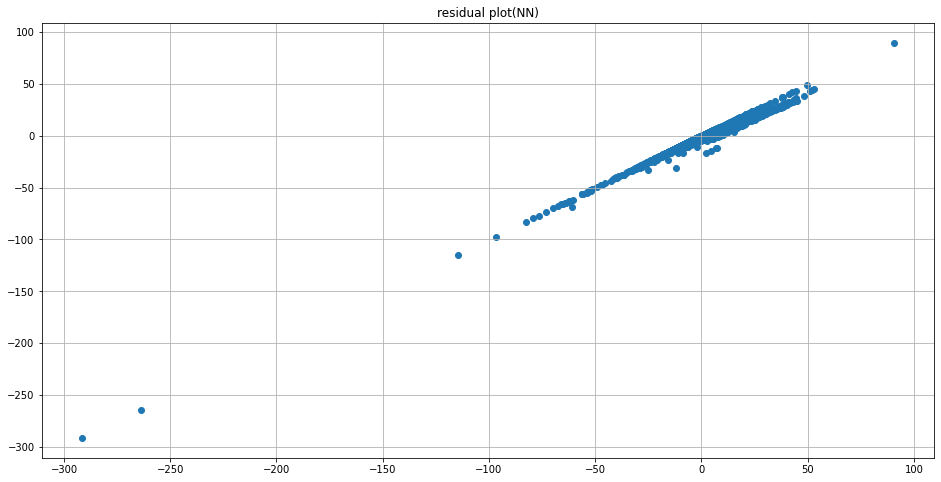

In [29]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_nn'], en_df['pred_nn'] - en_df['target'])
plt.title("residual plot(NN)")
plt.grid(True)
plt.show()

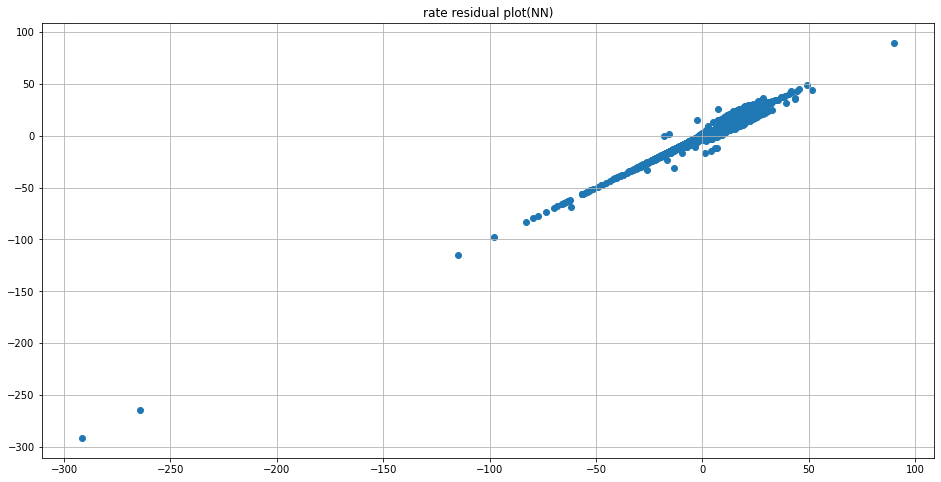

In [30]:
plt.figure(figsize=(16, 8))
plt.scatter(en_df['pred_rate_nn'], en_df['pred_rate_nn'] - en_df['real_rate'])
plt.title("rate residual plot(NN)")
plt.grid(True)
plt.show()

In [31]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/nft-appraiser/nft-appraiser/be80106205ee459583c583d4bd117973
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [3200]          : (0.07594655454158783, 9.95309829711914)
COMET INFO:     epoch_duration [200]       : (0.16297690500505269, 0.5110740909876768)
COMET INFO:     loss [200]                 : (0.4539690315723419, 1.2154865264892578)
COMET INFO:     val_loss [200]             : (0.3164970278739929, 0.7619597911834717)
COMET INFO:     validate_batch_loss [1200] : (0.07539311051368713, 1.8232684135437012)
COMET INFO:   Others:
COMET INFO:     trainable_params : 9377
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad         : False
COMET INFO:     Adam_beta_1          : 0.9
COMET INFO:     Adam_beta_2          : 0.999
CO